In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

### Introduction of the paramaters for the optimization problem

In [30]:
#parameters of the problem
n = 10 # dimension of the problem 
d = 100 # Number of constraints
lambdad = 10

np.random.seed(43)
X = np.random.rand(n,d)
np.random.seed(12)
y = np.random.rand(n)
Q = np.eye(n)
e = np.array([1 for i in range(2*d)])
p = np.dot(y,-1)
F = np.concatenate((X.T, - X.T), axis = 0)
b = np.dot(lambdad,e)
eps = 10e-8
t = 1
Mu = [2,15,50,100, 500]

The original problem we want to solve is:
$$
\begin{equation}
\begin{aligned}
    \text{minimize} & \quad  v^tQv + p^Tv \\
    \text{subject to} & \quad X^Tv \leq \lambda e \\
                      & \quad -X^Tv \leq \lambda e
\end{aligned}
\end{equation}
$$

We want to apply Newton's method on the following function : 
$$
f_0(x) = \frac{1}{2}x^T Q x + p^Tx  + \phi(x)
$$ where 
$$
\phi(x) = -\sum\limits_{i = 1}^{2d}\log(\lambda - f_i^Tx)
$$
We'll deal here in this case with no equality constraint, which simplify a bit the resolution.
We have :
$$
\nabla f_0(x) = Qx + p + \sum \limits_{i = 1}^{2d} \displaystyle\frac{f_i}{\lambda - f_i^Tx},
$$
and 
$$
\nabla^2 f_0(x) = Q + \sum\limits_{i = 1}^{2d}\displaystyle \frac{f_i f_i^T}{(f_i^T x - \lambda)^2}.
$$

Computation of the hessian $\nabla^2 f_t$

In [24]:
def hess_f_t(Q,p,A,b,x,t): #evaluate the hessian of f at x
    """
    return the hessian of the objective function at x

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        hessian of f_0(x) : (array), sized [n,n]
    """
    hess = Q*t
    for i in range(2*d):
        f_i = A[i] #ième ligne 
        mat = np.array([[f_i[i]*f_i[j] for i in range(n)] for j in range(n)])
        hess += mat/(np.dot(f_i,x) - b[i])**2
    return hess

Computation of the jacobian $\nabla f_t$

In [25]:
def grad_f_t(Q,p,A,b,x,t):
    """
    return the gradient of the objective function at x

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (array), sized [n,]
    """
    grad = t*(np.dot(Q,x) + p)
    for i in range(2*d):
        f_i = A[i]
        grad += f_i/(b[i] - np.dot(f_i,x))
    return grad

Computation of the log-barrier function $\phi$

In [5]:
def log_barrier(A,b,x):
    """
    computation of the log_barrier function at x, return infinity if out of the domain
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d, ]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        phi(x) : (int)
    """
    phi = 0
    check = np.all(A @ x <= b)
    if not check:
        return math.inf
    for i in range(2*d):
        f_i = A[i]
        phi -= np.log(b[i] - np.dot(f_i,x))
    return phi

Computation of the objective function $f_t$

In [6]:
def f_t(Q,p,A,b,x,t):
    """
    return the objective function evaluated at x
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (int)
    """
    f = t*(1/2*np.dot(x,np.dot(Q,x)) + np.dot(p,x))
    phi = log_barrier(A,b,x)
    return f + phi

In [7]:
def f_0(Q,p,x):
    """
    return the objective function evaluated at x, without log_barrier function
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (int)
    """
    f = (1/2*np.dot(x,np.dot(Q,x)) + np.dot(p,x))
    return f

### Phase I method

To find a feasible method, one should solve the following optimization problem:
$$
\begin{equation}
\begin{aligned}
    \text{minimize}_{s,v} & \quad s \\
    \text{subject to} & \quad X^Tv \leq \lambda e + s \\
                      & \quad -X^Tv \leq \lambda e + s
\end{aligned}
\end{equation}
$$
Noting 
$F = \large \begin{pmatrix}
    X^T & -e_d\\
    -X^T & -e_d\\
\end{pmatrix} \in \mathbb{R}^{2d \times (n + 1)}
$
and 
$V = \large \begin{pmatrix}
v \\
s
\end{pmatrix} \in \mathbb{R}^{n + 1},
$
it is reformulated as:
$$
\begin{equation}
\begin{aligned}
    \text{minimize}_{V} & \quad c^T V \\
    \text{subject to} & \quad FV \leq \lambda e_{2d}, \\
\end{aligned}
\end{equation}
$$
with $c = (0 \cdots 0 1)^T \in \mathbb{R}^{n + 1}$

hoping that the $s^\star < 0$. If there is equality constraints, it is exactly the same.

### Phase II method

This time, solve:
$$
\begin{equation}
\begin{aligned}
    \text{minimize}_{\mathbf{s}, \mathbf{s}', \mathbf{v}} & \quad \mathbb{1}^T \mathbb{s} + \mathbb{1}^T \mathbb{s} '\\
    \text{subject to} & \quad X^Tv \leq \lambda e + \mathbf{s} \\
                      & \quad -X^Tv \leq \lambda e + \mathbf{s}' \\
                      & \quad \mathbf{s} \geq 0, \mathbf{s}' \geq 0
\end{aligned}
\end{equation}
$$
Noting
$F = \large \begin{pmatrix}
    X^T & -I_d & O_d \\
    -X^T & O_d & -I_d\\
\end{pmatrix} \in \mathbb{R}^{2d \times (n + 2d)}
$
and
$V = \large \begin{pmatrix}
v \\
s \\
s'
\end{pmatrix} \in \mathbb{R}^{n + 2d},
$
it is reformulated as:
$$
\begin{equation}
\begin{aligned}
    \text{minimize}_{V} & \quad c^T V \\
    \text{subject to} & \quad FV \leq \lambda e_{2d}, \\
                      & \mathbf{s} \geq 0, \mathbf{s}' \geq 0
\end{aligned}
\end{equation}
$$
with $c = (0 \cdots 0 1 \cdots 1)^T \in \mathbb{R}^{n + 2d}$


In [8]:
def feasible_point_phase_I(A_ineq, b_ineq, A_eq = None, b_eq = None):
    """
    Find a feasible point by solving a linear programming problem. Phase I method is employed.
    There is two variables: x and s. The goal is to find the smallest s possible 
    such that A_ineq x <= s and A_eq = b. 
    This optimization problem has two variables, x and s. 
    """
    m, n = A_ineq.shape
    c = np.zeros((n + 1))
    c[-1] = 1

    A_aug = np.hstack((A_ineq, -np.ones((m,1)))) #Augmented matrix to take into account the s variable

    from scipy.optimize import linprog
    bounds = [(None, None)]*(n+1)
    res = linprog(c = c, A_ub = A_aug, b_ub = b_ineq, A_eq = A_eq, b_eq = b_eq, bounds = bounds, method = 'highs')
    if res.success:
        return res.x[:-1]
    else:
        raise ValueError("Problem infeasible.")

def feasible_point_phase_II(A_ineq, b_ineq, A_eq = None, b_eq = None):
    """
    Find a feasible point by solving a linear programming problem. Phase II method is employed.
    There is two variables: x and s. The goal is to find the smallest s possible 
    such that A_ineq x <= s and A_eq = b.
    This optimization problem has two variables, x and s.
    """
    m, n = A_ineq.shape
    c = np.zeros((n + m))
    c[n:] = 1
    U1 = np.concatenate((-np.eye(m//2), np.zeros((m//2,m//2))), axis = 1)
    U2 = np.concatenate((np.zeros((m//2,m//2)), -np.eye(m//2)), axis = 1)
    U = np.concatenate((U1, U2), axis = 0)
    A_aug = np.hstack((A_ineq, U)) #Augmented matrix to take into account the s variable

    from scipy.optimize import linprog
    bounds = [(None, None)]*n + [(0,None)]*m
    res = linprog(c = c, A_ub = A_aug, b_ub = b_ineq, A_eq = A_eq, b_eq = b_eq, bounds = bounds, method = 'highs')
    if res.success:
        return res.x[:-1]
    else:
        raise ValueError("Problem infeasible.")

feasible_point_phase_II(F, b)

def check_feasible_point(x: np.ndarray, A_ineq: np.ndarray, b_ineq: np.ndarray, A_eq: np.ndarray = None, b_eq: np.ndarray = None) -> bool:
    """
    Function to check if a point is actually feasible.
    Parameter:
        x: check if it is feasible
        A_ineq: inequality matrix
        b_ineq: r.h.s inequality
        A_eq: equality matrix
        b_eq: r.h.s equality
    return:
        A boolean. True if the boolean is feasible, False otherwise.
    """
    if (A_eq, b_eq) != (None, None): 
        assert A_eq @ x == b_eq, "The equality constraints are not respected"
    if np.any(A_ineq @ x > b_ineq):
        return False
    return True

### Classic backtracking

Implementation of the backtracking, with $\omega_1 = 10^{-4}$ and $\tau = 0.2$.

In [9]:
def backtracking(Q,p,A,b,x,t,dir):
    """
    return the right step validating Armijo's rule.

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
        dir: (array) the descent direction at iteration k, sized [n,]

    Returns:
        alpha : (int) the step for gradient descent according to armijo's rule
    """
    k = 0
    w = 10e-4
    tau = 0.5
    alpha = 1

    grad_f = grad_f_t(Q,p,A,b,x,t)
    x_new = x + alpha*dir
    f = f_t(Q,p,A,b,x,t)
    diff = f_t(Q,p,A,b,x_new,t) - (f + w*alpha*np.dot(dir,grad_f))
    while (diff > 0 and k < 4):
        k += 1
        alpha *= tau
        x_new = x + alpha*dir
        diff = f_t(Q,p,A,b,x_new,t) - (f + w*alpha*np.dot(dir,grad_f))
      #  print('dir = ', dir, 'x = ', x, 'alpha = ', alpha ,'diff = ', diff )
       # print('diff = ', diff )
    return alpha

### gradient-based backtracking

In [10]:
def backtracking_with_gradient(Q,p,A,b,x,t,dir):
    """
    return the right step validating Armijo's rule.

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
        dir: (array) the descent direction at iteration k, sized [n,]

    Returns:
        alpha : (int) the step for gradient descent according to armijo's rule
    """
    k = 0
    w = 10e-4
    tau = 0.05
    alpha = 1

    grad_f = grad_f_t(Q,p,A,b,x,t)
    x_new = x + alpha*dir

    grad_f_new = grad_f_t(Q,p,A,b,x_new,t)
    diff = np.linalg.norm(grad_f_new)**2 - np.linalg.norm(grad_f)**2*(1 - w*alpha)
    while (diff > 0):
        k += 1
        alpha *= tau
        x_new = x + alpha*dir 
        grad_f_new = grad_f_t(Q,p,A,b,x_new,t) #With new alpha
        diff = np.linalg.norm(grad_f_new)**2 - np.linalg.norm(grad_f)**(1 - w*alpha)
       # print('dir = ', dir, 'x = ', x, 'alpha = ', alpha ,'diff = ', diff )
    return alpha

Check whether the solution position is feasible, i.e., if
$$
Fx \leq b
$$
or more precisely if $\forall i \in \{1,2d\}$
$$
f_i^Tx \leq \lambda
$$
where $f_i$ is the $i^{th}$ row of F and F is defined as 
$$
F = \large \begin{pmatrix}
    X^T \\
    -X^T \\
\end{pmatrix}
$$

### Centering step

This is the crucial step where we solve the minimization problem via Newton's method for a fixed $t$.

In [11]:
def centering_step(Q: np.ndarray[np.ndarray],p: np.ndarray, A: np.ndarray,b: np.ndarray,t: float, v0: np.ndarray, eps: float, backtrack = 'gradient'):
    """
    It computes the Newton method to solve the problem \grad f_t(x) = 0

    Args : 
        Q: (array) positive definite matrix, sized [n,n]
        p: (array), sized [n,]
        F: (array), matrix of the inequality constraint Fx <= h and appearing in the barrier function, sized [d,n]
        t: (int) parameter of the barrier method
        v0: (array) initialisation point, in the strictly feasible domain, sized [n,]
        eps: (int) accepted error/target precision

    Returns:
        The list of iterates x until convergence at precision epsilon
    """
    V = [v0]
    x = v0
    grad_f = grad_f_t(Q,p,A,b,x,t)
    hess_f = hess_f_t(Q,p,A,b,x,t)
    dir = - np.linalg.solve(hess_f, grad_f)
    criteria = np.dot(hess_f, dir)
    criteria = np.dot(dir,criteria)
    n_iter = 0

    while (criteria > 2*eps): #criteria to stop iterations
        if backtrack == "gradient":
            alpha = backtracking_with_gradient(Q,p,A,b,x,t, dir)
        elif backtrack == "Vanilla":
            alpha = backtracking(Q,p,A,b,x,t, dir)
        x = x + alpha*dir

        #computation of derivatives
        grad_f = grad_f_t(Q,p,A,b,x,t)
        hess_f = hess_f_t(Q,p,A,b,x,t)

        #computation of criteria
        criteria = np.dot(hess_f, dir)
        criteria = np.dot(dir,criteria)

        #new direction
        dir = - np.linalg.solve(hess_f, grad_f)
        V += [x]

        n_iter += 1 #every passage in the loop is a Newton iteration
    return V, n_iter

### Barrier method

We solve here the centering problem to draw a central path in the strictly feasible domain $\mathcal{D} = \{x \in \mathbf{R}^n | Fx < \lambda e_{2d}\}$. An obvious point here is $v_0 = O_{n}$, since $\lambda > 0$. We do it for several values of $\mu$.

The principle is the following. For $\mu$ fixed, you solve the unconstrained problem, called the centering step. Then, you increase the penalizing term by $\mu > 1$.

In [12]:
def barr_method(Q: np.ndarray[np.ndarray], p: np.ndarray, A:np.ndarray, b:np.ndarray, v0:np.ndarray ,eps: float, backtrack:float = "gradient"):
    X = [[] for i in range(5)]
    N_iter = [[] for i in range(len(Mu))]
    for i in range(len(Mu)):
        t = 1
        x = v0
        while (2*d/t > eps):
            V, n_iter = centering_step(Q, p, A, b, t, x, eps, backtrack) #n_iter is the number of column of V
            t *= Mu[i]
            x = V[-1] #Principle of the central path : we start from the last solution computed previously
            N_iter[i] += [n_iter]
            X[i] += [x] #sequence of iteration for this t*mu
    return X, N_iter

## Results

### For classical backtracking and $\epsilon = 10^{-8}$

For $n = 100$

C:\Users\hugon\AppData\Local\Temp\ipykernel_27600\1803565017.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  diff = f_t(Q,p,A,b,x_new,t) - (f + w*alpha*np.dot(dir,grad_f))


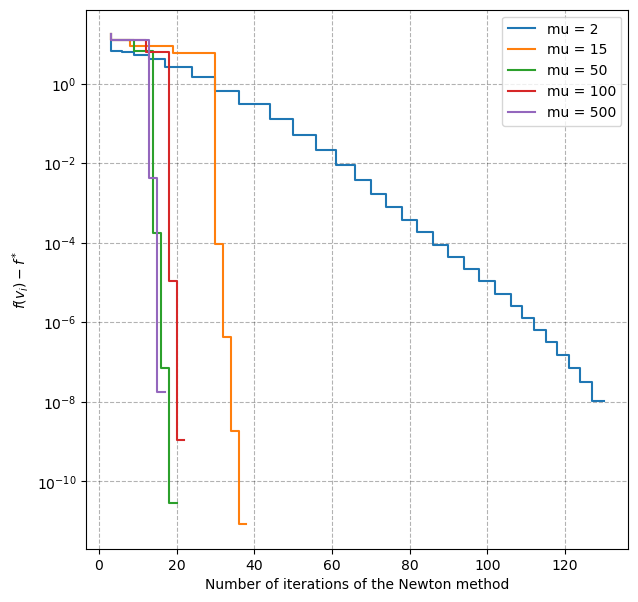

In [26]:
v0 = feasible_point_phase_I(F,b)
X, N_iter = barr_method(Q,p,F,b,v0,eps, backtrack="Vanilla")

for i in range(len(Mu)):
    plt.figure(num=1,figsize=(7,7)) 
    n_iter = N_iter[i]
    Newton_iter = np.cumsum(n_iter) #abscisse
    V = X[i] #give me the sequence for this mu
    f = [f_0(Q,p,V[j]) for j in range(len(V))] #I evaluate at every sequence the objective function
    gap = [f_0(Q,p,[0 for i in range(n)]) - f[-1]] + [p - f[-1] for p in f[:-1]] #This is the gap at every iteration
    plt.step(Newton_iter, gap, label='mu = '+str(Mu[i]))
    plt.figure(1)
    plt.legend(loc = 'upper right')
    plt.semilogy()
    plt.xlabel('Number of iterations of the Newton method')
    plt.ylabel('$f(v_i)-f^*$')
    plt.rc('grid', linestyle="--", color='black',alpha = 0.3)
    plt.grid(True)

For n = 10

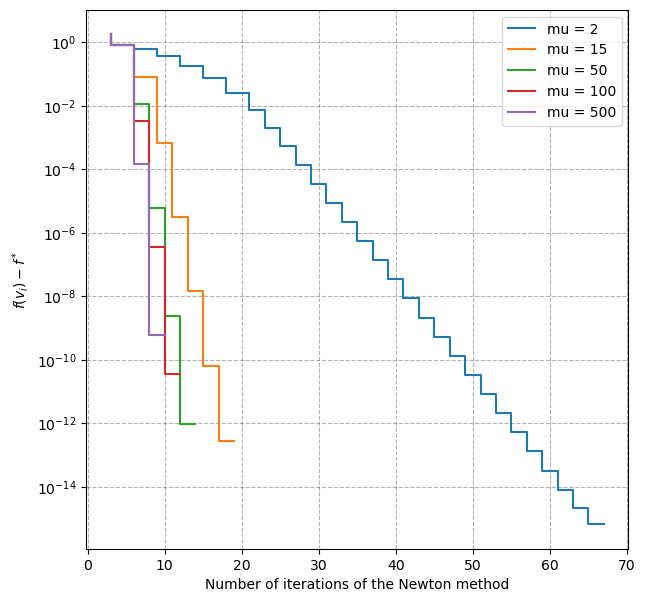

In [31]:
v0 = feasible_point_phase_I(F,b)
X, N_iter = barr_method(Q,p,F,b,v0,eps, backtrack="Vanilla")

for i in range(len(Mu)):
    plt.figure(num=1,figsize=(7,7)) 
    n_iter = N_iter[i]
    Newton_iter = np.cumsum(n_iter) #abscisse
    V = X[i] #give me the sequence for this mu
    f = [f_0(Q,p,V[j]) for j in range(len(V))] #I evaluate at every sequence the objective function
    gap = [f_0(Q,p,[0 for i in range(n)]) - f[-1]] + [p - f[-1] for p in f[:-1]] #This is the gap at every iteration
    plt.step(Newton_iter, gap, label='mu = '+str(Mu[i]))
    plt.figure(1)
    plt.legend(loc = 'upper right')
    plt.semilogy()
    plt.xlabel('Number of iterations of the Newton method')
    plt.ylabel('$f(v_i)-f^*$')
    plt.rc('grid', linestyle="--", color='black',alpha = 0.3)
    plt.grid(True)

### With gradient-based backtracking and $\epsilon = 10^{-8}$

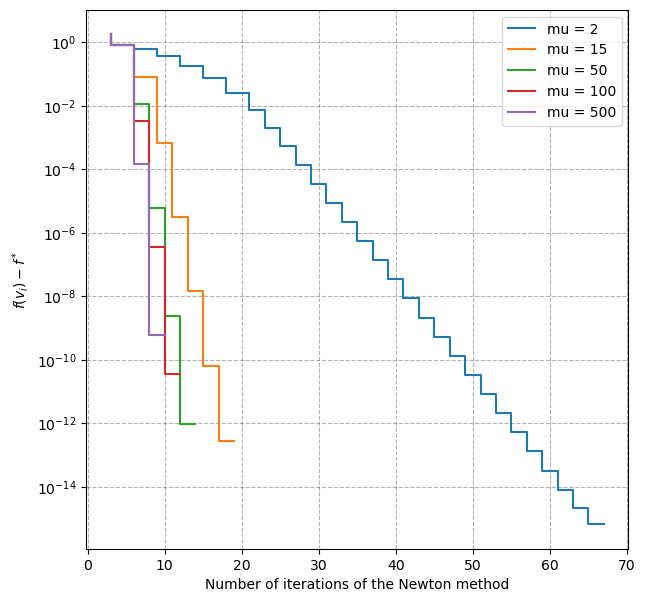

In [17]:
v0 = feasible_point_phase_I(F,b)
X_grad, N_iter = barr_method(Q,p,F,b,v0,eps)

for i in range(len(Mu)):
    plt.figure(num=1,figsize=(7,7)) 
    n_iter = N_iter[i]
    Newton_iter = np.cumsum(n_iter) #abscisse
    V = X_grad[i] #give me the sequence for this mu
    f = [f_0(Q,p,V[j]) for j in range(len(V))] #I evaluate at every sequence the objective function
    gap = [f_0(Q,p,[0 for i in range(n)]) - f[-1]] + [p - f[-1] for p in f[:-1]] #This is the gap at every iteration
    plt.step(Newton_iter, gap, label='mu = '+str(Mu[i]))
    plt.figure(1)
    plt.legend(loc = 'upper right')
    plt.semilogy()
    plt.xlabel('Number of iterations of the Newton method')
    plt.ylabel('$f(v_i)-f^*$')
    plt.rc('grid', linestyle="--", color='black',alpha = 0.3)
    plt.grid(True)

At the end, the minimum found is: $f(x^*) \approx -1.76$.

### Resolution via a genetic algorithm.

Recall that $v \in \mathbb{R}^n$

In [19]:
def f_0_gen(Q: np.ndarray[np.ndarray],p: np.ndarray, F:np.ndarray[np.ndarray], b: np.ndarray, x: np.ndarray, penalty: float = 1e3):
    """
    return the objective function evaluated at x, without log_barrier function
    Args : 
        x: (array) the point at which we evaluate the objective function, sized [n,]
        b: (array) rhs of the linear inequality, sized [2d,]
        F: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    
    The inequality constraint is F @ x <= b
    Returns:
        f_0(x) : (int)
    """
    r = np.sum((np.maximum(0, F @ x - b))**2)
    f = 1/2*np.dot(x,np.dot(Q,x)) + np.dot(p,x) + penalty*r
    return f

In [33]:
from inspyred.benchmarks import Benchmark
import inspyred
from inspyred import ec
from random import Random
from time import time

np.random.seed(43)
X = np.random.rand(n,d)
np.random.seed(12)
y = np.random.rand(n)
Q = np.eye(n)
e = np.array([1 for i in range(2*d)])
p = np.dot(y,-1)
F = np.concatenate((X.T, - X.T), axis = 0)
b = np.dot(lambdad,e)
penalty = 1e3


def generator(random, args): # génération de la population initiale
    return [random.uniform(-1.0, 1.0) for _ in range(n)] #generation aleatoire sur les domaines de définitions des variables

def evaluator(candidates, args=0): # evaluation des points 
    fitness = []
    for c in candidates: #Browse the batch
        total = 0
        for i in range(len(c)):
            total += f_0_gen(Q, p, F, b, c, penalty) # fonction Rosenbrock
        fitness.append(total)
    return fitness

# Definition du problème d'optimisation via GA en utilisant Inspyred
prng = Random()
prng.seed(time())
ea = inspyred.ec.GA(prng)
ea.terminator = inspyred.ec.terminators.evaluation_termination
final_pop = ea.evolve(generator=generator, #renseignement de la fonction de generation
                      evaluator=evaluator,  #renseignement de la fonction d'évaluation
                      pop_size=2000,
                      maximize=False,  #renseignement du choix de maximisation ou minimisation
                      max_evaluations=1000,
                      crossover_rate=.6,
                      mutation_rate=0.8,
                      selector = inspyred.ec.selectors.tournament_selection, #choix de l'opérateur de sélection
                      variator=[inspyred.ec.variators.crossovers.simulated_binary_crossover,inspyred.ec.variators.mutators.gaussian_mutation], # choix des opérateurs de crossover et mutation
                      replacer=inspyred.ec.replacers.truncation_replacement)# choix de l'opérateur de remplacement

stats = inspyred.ec.analysis.fitness_statistics(final_pop)
print('best',stats['best'])
print('worst',stats['worst'])
print('mean',stats['mean'])
print('median',stats['median'])
print('std',stats['std'])
print('location', final_pop[0].candidate)
print(f'Global argmin is {-p}')

print(f"Best minimum is {f_0_gen(Q, p, F, b, final_pop[0].candidate, penalty = 0)}")

best -14.893361927767861
worst 57.89630713016372
mean 16.92457913375094
median 16.301695824019262
std 11.648207879206893
location [-0.12172865817744882, 0.6232669818355148, -0.17713475996027217, 0.6509049200041228, 0.20583148836343867, 0.9024986556581278, 0.930376308349532, 0.35052141816712457, 0.7200859655517424, 0.3526470948510483]
Global argmin is [0.15416284 0.7400497  0.26331502 0.53373939 0.01457496 0.91874701
 0.90071485 0.03342143 0.95694934 0.13720932]
Best minimum is -1.4893361927767859
